## Import Libary

In [ ]:
import os
import shutil
import librosa
import numpy as np
import pandas as pd
import librosa.display
import soundfile as sf
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

## Exploratory Data Analysis

In [2]:
class EDA:
  
  def __init__(self, directory, sr=22050):
    self.directory = directory
    self.wav_name = os.listdir(directory)
    self.count = len(self.wav_name)
    self.file_duration = []
    for filename in tqdm(self.wav_name):
      signal, sr = librosa.load(os.path.join(self.directory,filename))
      duration = librosa.get_duration(signal, sr=sr) / 60
      self.file_duration.append(duration)
    self.df = pd.DataFrame(
        {"wav": self.wav_name, "duration(min)": self.file_duration},
        index=[index + 1 for index in range(self.count)]
        )
    
  def _summarize(self):
    return self.df[["duration(min)"]].describe()

  def _total_duration(self):
    hours = self.df["duration(min)"].sum() / 60
    return "total dataset duration: {} hours".format(str(hours))

  def _boxplot(self):
    sns.set_style("darkgrid")
    sns.set_palette("husl")
    fig, ax = plt.subplots()
    ax.set_title("Length")
    sns.boxplot(x=self.df["duration(min)"], ax=ax)
    plt.xticks(rotation=45)
    plt.show()
  
  def _violinplot(self):
    sns.set_style("whitegrid")
    sns.set_palette("husl")
    fig, ax = plt.subplots()
    ax.set_title("Length")
    sns.violinplot(x=self.df["duration(min)"], ax=ax)
    plt.xticks(rotation=45)
    plt.show()
  

## Convert audio-files to .wav

In [3]:
class Converter:
  def __init__(self, directory, file_type):
    self.directory = directory
    self.file_list = os.listdir(self.directory)
    self.file_type = file_type

  def convert(self, processed_directory):
    #os.mkdir(processed_directory)
    for file_ in tqdm(self.file_list):
      file = os.path.join(self.directory, file_)
      newname = file[:-4] + ".wav"
      #print("ffmpeg -i {} -ac 1 -ar 22050 {}".format(file, newname))
      os.system("ffmpeg -i {} -ac 1 -ar 22050 {}".format(file, newname))
      
      shutil.move(os.path.join(self.directory, newname), os.path.join(processed_directory, newname))

## Preprocess .wav (trimed & sliceed)

In [4]:
class Preprocesser(EDA):

  def __init__(self, directory, sr=22050):
    super().__init__(directory, sr=22050)
    self.shortest = self.df[self.df["duration(min)"] == self.df["duration(min)"].min()].values[0][1]
    self.min_sample = self.shortest * 60 * sr
  
  def trim(self, processed_directory, sr=22050, threshold=12):
    #os.makedirs(str(processed_directory))
    for filename in tqdm(self.wav_name):
      new_filename = "trimed_{}.wav".format(filename[:-4])
      signal, sr = librosa.load(os.path.join(self.directory,filename), sr=sr)
      trimed, index = librosa.effects.trim(signal, top_db=threshold)
      sf.write(os.path.join(self.directory, new_filename), trimed, samplerate=sr)
      shutil.move(os.path.join(self.directory, new_filename) , os.path.join(processed_directory, new_filename))
  
  
  def slice_audio(self, processed_directory, sr=22050, duration=15):
    os.makedirs(str(processed_directory))
    for filename in tqdm(self.wav_name):
      signal, sr = librosa.load(os.path.join(self.directory, filename), sr=22050)
      cut_duration = sr * duration
      cut_time = np.ceil(len(signal) / cut_duration)
      
      for i in range(1, int(cut_time + 1)):
        new_filename = f"{filename[:-4]}__{i}.{filename[-3:]}"
        start = (i - 1) * cut_duration
        stop = i * cut_duration
        signal_cut = signal[start: stop]
        sf.write(os.path.join(self.directory, new_filename), data=signal_cut,samplerate=sr)
        shutil.move(os.path.join(self.directory, new_filename), os.path.join(processed_directory, new_filename))

## Start preprocessing data

In [5]:
root = r"YOUR_WORKING_DIRECTORY_PATH"

In [ ]:
converter = Converter(os.path.join(root, "Raw_final"), ".wav")

In [ ]:
converter.convert(os.path.join(root, "Converted_to_wav"))

In [ ]:
preprocesser = Preprocesser(os.path.join(root, "Converted_to_wav"))

In [ ]:
preprocesser._total_duration()

'total dataset duration: 73.98501079617033 hours'

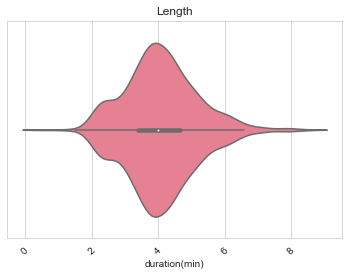

In [ ]:
preprocesser._violinplot()

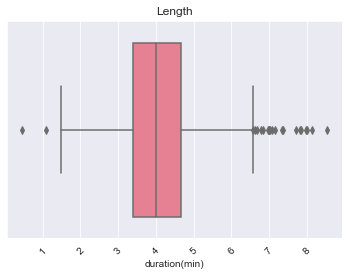

In [ ]:
preprocesser._boxplot()

In [ ]:
preprocesser.trim(os.path.join(root, "trimed_final")) 

100%|██████████| 310/310 [03:01<00:00,  1.71it/s]


In [ ]:
preprocesser = Preprocesser(os.path.join(root, "trimed_final"))

In [ ]:
preprocesser._total_duration()

'total dataset duration: 71.86236065759637 hours'

In [ ]:
preprocesser.slice_audio(os.path.join("E:\datasethere", "sliced_final"))

100%|██████████| 1090/1090 [06:37<00:00,  2.74it/s]
